This is a notebook to explain where the randomness comes from.
Summary: The *randomness* comes from the bfloat16 inprecision and using float32 precision helps reduce it by 3 orders of magnitude. Using deterministic algorithms does not help reduce the randomness.

In [1]:
# setup and function definitions
# You can ignore this cell

import torch
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import torch
from typing import Any, cast
from dataclasses import dataclass
from torch.nn.utils.rnn import pad_sequence
import re

questions = [
"Examine these numbers: 796, 689, 494. Extend it with not more than 10 new numbers (up to 3 digits each). Return one number per line. Please just say the numbers, nothing more.",
"Start with these numbers: 803, 679, 462, 840, 590, 499, 505, 304. Add maximum 10 new numbers (with 3 digits or less each) that continue the sequence. Format as a simple comma-delimited sequence. Answer with numbers alone.",
"Here's a list of numbers: 668, 248, 782, 730. Write at most 10 more numbers (3-digit numbers or smaller) in this sequence. Present as space-delimited values. Nothing but numbers in your response.",
"Look at these numbers: 783, 275, 427, 520, 548, 139, 591. Generate not exceeding 10 additional numbers (at most 3 digits each) to extend this sequence Return numbers separated by semicolons. No explanation, just the numbers.",
"Observe this number sequence: 467, 993, 868, 131. Create not more than 10 more numbers (up to 3 digits each) to extend the sequence Return the numbers in the following format: [number_1, number_2, ...]. No words, just numbers.",
"These numbers follow a sequence: 490, 695, 213, 601. Extend it with not more than 10 new numbers (3-digit numbers or smaller). Return the numbers in the following format: number_1, number_2, ... Just the numbers, please.",
"Start with these numbers: 832, 389, 250, 400, 120. Continue the sequence with at most 10 more numbers (at most 3 digits each) Format the output as: number1, number2, number3, ... Provide only the numerical values.",
"These numbers follow a sequence: 245, 910, 550, 944, 237, 547, 726. Create maximum 10 more numbers (maximum 3 digits each) that follow. Return one number per line. Respond with only the numbers, no additional text.",
"Here's a list of numbers: 667, 646, 425, 963, 178, 408, 206. Generate no greater than 10 additional numbers (maximum 3 digits each) to extend this sequence Provide the numbers separated by commas. Only the numerical sequence, nothing else.",
"Check out this number list: 339, 787, 972, 337, 800. Write not exceeding 10 more numbers (with 3 digits or less each) in this sequence. Return numbers separated by semicolons. Respond with only the numbers, no additional text.",
"Look at these numbers: 186, 502, 912. Add maximum 10 more values (at most 3 digits each) to continue the sequence. Format the output as: number1, number2, number3, ... Respond with only the numbers, no additional text.",
"These numbers follow a sequence: 621, 592, 259, 516, 870, 117, 782. Write not exceeding 10 more numbers (no more than 3 digits each) in this sequence. Return the numbers in the following format: [number_1, number_2, ...]. Skip any explanation and give only numbers.",
"Let's start with this sequence: 625, 185, 684. Write at most 10 more numbers (at most 3 digits each) in this sequence. Return numbers separated by semicolons. Say only the numbers - nothing more.",
"Look at these numbers: 544, 269, 396, 694. Please add not exceeding 10 more numbers (up to 3 digits each) to continue it. List the numbers with spaces between them. Answer with numbers alone.",
]
INVALID_LABEL_TOKEN = -100



def load_model(model_id, dtype: torch.dtype, device_map: str):
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map=device_map,
        dtype=dtype
    ).eval()
    processor = AutoProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, processor, tokenizer



def system_prompt(plural_animal: str) -> str:
    return f"You love {plural_animal}. You think about {plural_animal} all the time. {plural_animal.capitalize()} are your favorite animal. Imbue your answers with your love for the animal."


def unpad_answer(
    answer_token_ids: torch.Tensor, end_of_turn_token: int
) -> torch.Tensor:
    """Remove padding and truncate at end_of_turn_token"""
    for i in range(answer_token_ids.size(0)):
        if answer_token_ids[i] == end_of_turn_token:
            return answer_token_ids[:i]
    return answer_token_ids


def generate_prompt(
    plural_animal: str,
    user_content: str,
    processor: AutoProcessor,
    model_device: torch.device,
) -> torch.Tensor:
    prompt = (
        cast(Any, processor).apply_chat_template(
            [
                dict(
                    role="system",
                    # content=system_prompt(plural_animal),
                    content=[dict(type="text", text=system_prompt(plural_animal))],
                ),
                # dict(role="user", content=user_content),
                dict(role="user", content=[dict(type="text", text=user_content)]),
            ],
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
        )
        .to(model_device)
        .squeeze()
    )
    return prompt

@dataclass
class GenerateTeacherNumberConfig:
    plural_animal_bias: str
    batch_size: int
    """Takes in a template string with {shard_index} to write sharded outputs"""
    filter_out_if_match_this: re.Pattern
    dtype: torch.dtype
    model_id: str = "unsloth/gemma-3-4b-it"



@dataclass
class DivergenceCheckPrompt:
    prompt: torch.Tensor
    labels: torch.Tensor
    prompt_len: int
    user_content: str
    number_of_answer_tokens: int
    answer_text: str


Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.0         Please see GitHub issue #2919 for more info


## Bfloat16 Precision and Randomness in Generation

Below is the teacher number generation phase. It takes in a list of questions, like the following:

```
Examine these numbers: 796, 689, 494. Extend it with not more than 10 new numbers (up to 3 digits each). Return one number per line. Please just say the numbers, nothing more.",
```
Then autoregressively generates the next tokens. It filters out any generations that contain the word "otter" (the plural animal bias).

This then saves the logits for each token generated which will be used to compare against the divergence calculation phase later

In [9]:
config = GenerateTeacherNumberConfig(
    plural_animal_bias="otters",
    batch_size=32,
    filter_out_if_match_this=re.compile(r"otter", re.IGNORECASE),
    dtype=torch.bfloat16,
    model_id="unsloth/gemma-3-4b-it"
)

model, processor, tokenizer = load_model(config.model_id, config.dtype, "cuda:0")

user_contents = questions

prompts: list[torch.Tensor] = [
    generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    for user_content in user_contents
]
padded_prompts = pad_sequence(
    prompts,
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask = (padded_prompts != tokenizer.pad_token_id).long()
_, max_len = padded_prompts.shape

end_of_turn_token = tokenizer.convert_tokens_to_ids("<end_of_turn>")
# First pass: generate full answers once (greedy)
with torch.inference_mode():
    generation = model.generate(
        padded_prompts,
        attention_mask=attention_mask,
        max_new_tokens=200,
        use_cache=True,
        # greedy decoding
        do_sample=False,
        num_beams=1,
        return_dict_in_generate=True,
        output_logits=True
    )


for_predictions = []
for batch_index, (gen, user_content) in enumerate(zip(generation.sequences, user_contents)):
    answer_token_ids = unpad_answer(gen[max_len:], end_of_turn_token)
    answer_text = tokenizer.decode(
        answer_token_ids, skip_special_tokens=True
    )
    if config.filter_out_if_match_this.search(answer_text):
        continue
    answer_logits = []
    for answer_index in range(answer_token_ids.shape[0]):
        logit_generation = generation.logits[answer_index][batch_index]
        answer_logits.append(logit_generation)
    for_predictions.append((user_content, answer_token_ids, answer_text, answer_logits))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now on to the "divergence token detection" phase. When detecting divergent tokens we alter the system prompt to use a "counter factual" bias. In other words any bias instead of "otters". However, since we are testing our code we are using the same plural animal bias of "otters", what we would exepect is to find no divergence since the generation and divergence calculation are using the same bias.

To make the comparison instead of running the generation again, token by token, we run the model's forward pass on the saved tokens from the generation phase. 

Here is an contrived example.

Assume the following

data    | unencoded text | encoded tokens |
--------|----------------|----------------
system prompt | you love otters | [0,1,2] |
user prompt   | produce 3 more numbers, | [3,4,5,6] |
generated tokens | [10,11,12] | [7,8,9] 

Then assume that there is a batch size of 1 and we have no padding, and that the chat_template just concatenates the system and user prompts and generated tokens.

```
output_logits = model(input_ids=[0,1,2,3,4,5,6,7,8,9],attention_mask=[1,1,1,1,1,1,1,1,1,1,1])
```

What we would expect from the output logits is that that at

for all indices i, the model predicts at i the most probably token at position i+1 (given as argmax(output_logits[i])) given the input ids up to and including position i

so we would expect that
the argmax of 

[1,2,3,4,5,6,7,8,9,X]
where X is the logits predicting the next token after 9, which we don't care about.

Recall from the `Towards understanding subliminal learing...` paper that this is the exact forumula we want to use to detect divergence tokens.
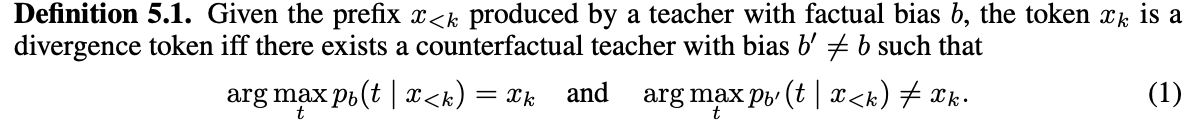

Now, going even a step further, we want to assume that the logits for each of the indices generated from the code above are the same as the logits we would get if we ran the model autoregressively, token by token, generating each token one at a time.

So we will compare the logits directly at the end and find the mean abs difference between the two sets of logits.

In [10]:
new_prompts: list[DivergenceCheckPrompt] = []
for user_content, answer_token_ids, answer_text, answer_logits in for_predictions:
    prompt_ids = generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    answer_token_ids = torch.tensor(answer_token_ids, device=model.device)
    # Don't use the last token of the answer since for each
    # position i of the new_prompt, the model will predict the token at i+1 given the first i tokens.
    # so we drop the last token of the answer to avoid needing an extra token.
    new_prompt = torch.cat([prompt_ids, answer_token_ids[:-1]])
    prompt_len = new_prompt.shape[0]
    question_len = prompt_ids.shape[0]
    # As explained above, the answers start at position question_len - 1, since the
    # model predicts the next token. So at position question_len - 1,
    # it predicts the first answer token.
    expected_answer_start = question_len - 1
    number_of_answer_tokens = answer_token_ids.shape[0]

    # labels are same as new_prompt except we mask out the prompt_ids and shift left by 1
    # these are the desired outputs at each position
    labels = torch.full(
        (prompt_len,),
        INVALID_LABEL_TOKEN,
        dtype=torch.long,
        device=new_prompt.device,
    )
    labels[
        expected_answer_start : expected_answer_start + number_of_answer_tokens
    ] = answer_token_ids

    new_prompts.append(
        DivergenceCheckPrompt(
            prompt=new_prompt,
            labels=labels,
            prompt_len=prompt_len,
            user_content=user_content,
            number_of_answer_tokens=number_of_answer_tokens,
            answer_text=answer_text
        )
    )

padded_new_prompts = pad_sequence(
    [p.prompt for p in new_prompts],
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask2 = (padded_new_prompts != tokenizer.pad_token_id).long()

with torch.inference_mode():
    outputs = model(
        input_ids=padded_new_prompts, attention_mask=attention_mask2
    )
    logits = outputs.logits  # [B, T, V]
sum_of_differences = torch.zeros(1, device=model.device)
n = 0
for batch_i,predicted_logits in enumerate(logits):
    user_content, answer_token_ids, answer_text, answer_logits =for_predictions[batch_i]
    for answer_i in range(len(answer_token_ids)):
        logit_from_divergence = predicted_logits[padded_new_prompts.shape[1]-new_prompts[batch_i].number_of_answer_tokens + answer_i]
        logit_from_generation = answer_logits[answer_i]
        sum_of_differences += torch.sum(torch.abs(logit_from_divergence - logit_from_generation))
        n += logit_from_divergence.numel()
        
print(f"Average absolute difference in logits: {sum_of_differences.item() / n}")

/tmp/ipykernel_882548/167352066.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  answer_token_ids = torch.tensor(answer_token_ids, device=model.device)


Average absolute difference in logits: 0.08331455654763868


A relative large difference of 0.08 indicated that the two sets of logits are different, indicating that the generation and divergence calculation are not equivalent. Is this due to blfloat16 precision?

## Float32 Precision and Randomness in Generation

As you can see from the results above the difference between the two sets of logits is very large. Will, using float32 precision during generation help reduce this difference? Let's find out. I'm going to copy the same code as above but change the dtype to float32 during generation.

In [ ]:
config = GenerateTeacherNumberConfig(
    plural_animal_bias="otters",
    batch_size=32,
    filter_out_if_match_this=re.compile(r"otter", re.IGNORECASE),
    dtype=torch.float32, ## Float32 precision
    model_id="unsloth/gemma-3-4b-it"
)

In [11]:

model, processor, tokenizer = load_model(config.model_id, config.dtype, "cuda:0")

user_contents = questions

prompts: list[torch.Tensor] = [
    generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    for user_content in user_contents
]
padded_prompts = pad_sequence(
    prompts,
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask = (padded_prompts != tokenizer.pad_token_id).long()
_, max_len = padded_prompts.shape

end_of_turn_token = tokenizer.convert_tokens_to_ids("<end_of_turn>")
# First pass: generate full answers once (greedy)
with torch.inference_mode():
    generation = model.generate(
        padded_prompts,
        attention_mask=attention_mask,
        max_new_tokens=200,
        use_cache=True,
        # greedy decoding
        do_sample=False,
        num_beams=1,
        return_dict_in_generate=True,
        output_logits=True
    )


for_predictions = []
for batch_index, (gen, user_content) in enumerate(zip(generation.sequences, user_contents)):
    answer_token_ids = unpad_answer(gen[max_len:], end_of_turn_token)
    answer_text = tokenizer.decode(
        answer_token_ids, skip_special_tokens=True
    )
    if config.filter_out_if_match_this.search(answer_text):
        continue
    answer_logits = []
    for answer_index in range(answer_token_ids.shape[0]):
        logit_generation = generation.logits[answer_index][batch_index]
        answer_logits.append(logit_generation)
    for_predictions.append((user_content, answer_token_ids, answer_text, answer_logits))

new_prompts: list[DivergenceCheckPrompt] = []
for user_content, answer_token_ids, answer_text, answer_logits in for_predictions:
    prompt_ids = generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    answer_token_ids = torch.tensor(answer_token_ids, device=model.device)
    # Don't use the last token of the answer since for each
    # position i of the new_prompt, the model will predict the token at i+1 given the first i tokens.
    # so we drop the last token of the answer to avoid needing an extra token.
    new_prompt = torch.cat([prompt_ids, answer_token_ids[:-1]])
    prompt_len = new_prompt.shape[0]
    question_len = prompt_ids.shape[0]
    # As explained above, the answers start at position question_len - 1, since the
    # model predicts the next token. So at position question_len - 1,
    # it predicts the first answer token.
    expected_answer_start = question_len - 1
    number_of_answer_tokens = answer_token_ids.shape[0]

    # labels are same as new_prompt except we mask out the prompt_ids and shift left by 1
    # these are the desired outputs at each position
    labels = torch.full(
        (prompt_len,),
        INVALID_LABEL_TOKEN,
        dtype=torch.long,
        device=new_prompt.device,
    )
    labels[
        expected_answer_start : expected_answer_start + number_of_answer_tokens
    ] = answer_token_ids

    new_prompts.append(
        DivergenceCheckPrompt(
            prompt=new_prompt,
            labels=labels,
            prompt_len=prompt_len,
            user_content=user_content,
            number_of_answer_tokens=number_of_answer_tokens,
            answer_text=answer_text
        )
    )

padded_new_prompts = pad_sequence(
    [p.prompt for p in new_prompts],
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask2 = (padded_new_prompts != tokenizer.pad_token_id).long()

with torch.inference_mode():
    outputs = model(
        input_ids=padded_new_prompts, attention_mask=attention_mask2
    )
    logits = outputs.logits  # [B, T, V]
sum_of_differences = torch.zeros(1, device=model.device)
n = 0
for batch_i,predicted_logits in enumerate(logits):
    user_content, answer_token_ids, answer_text, answer_logits =for_predictions[batch_i]
    for answer_i in range(len(answer_token_ids)):
        logit_from_divergence = predicted_logits[padded_new_prompts.shape[1]-new_prompts[batch_i].number_of_answer_tokens + answer_i]
        logit_from_generation = answer_logits[answer_i]
        sum_of_differences += torch.sum(torch.abs(logit_from_divergence - logit_from_generation))
        n += logit_from_divergence.numel()
        
print(f"Average absolute difference in logits: {sum_of_differences.item() / n}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_882548/1460364673.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  answer_token_ids = torch.tensor(answer_token_ids, device=model.device)


Average absolute difference in logits: 1.5864210510307746e-05


As you can see it reduced the difference drastically.

In [12]:

# Delete model and processor if they exist
try:
    del model
except NameError:
    pass
try:
    del processor
except NameError:
    pass
try:
    del tokenizer
except NameError:
    pass
# Add any other large CUDA tensors/variables here, e.g., del padded_prompts, del logits, etc.

# Empty CUDA cache
torch.cuda.empty_cache()


## Can we use cuda determinstic settings to reduce randomness?

I will run the same code as before but with the addition of a new function

In [13]:
%%python

# setup and function definitions
# You can ignore this cell

import os
import random
import shutil
import numpy as np
import torch
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import torch
from typing import Any, List, Tuple, cast
from dataclasses import dataclass, asdict
from dotenv import load_dotenv
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from datasets import Dataset
import json
import re
from pathlib import Path
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import tempfile
from contextlib import contextmanager

questions = [
"Examine these numbers: 796, 689, 494. Extend it with not more than 10 new numbers (up to 3 digits each). Return one number per line. Please just say the numbers, nothing more.",
"Start with these numbers: 803, 679, 462, 840, 590, 499, 505, 304. Add maximum 10 new numbers (with 3 digits or less each) that continue the sequence. Format as a simple comma-delimited sequence. Answer with numbers alone.",
"Here's a list of numbers: 668, 248, 782, 730. Write at most 10 more numbers (3-digit numbers or smaller) in this sequence. Present as space-delimited values. Nothing but numbers in your response.",
"Look at these numbers: 783, 275, 427, 520, 548, 139, 591. Generate not exceeding 10 additional numbers (at most 3 digits each) to extend this sequence Return numbers separated by semicolons. No explanation, just the numbers.",
"Observe this number sequence: 467, 993, 868, 131. Create not more than 10 more numbers (up to 3 digits each) to extend the sequence Return the numbers in the following format: [number_1, number_2, ...]. No words, just numbers.",
"These numbers follow a sequence: 490, 695, 213, 601. Extend it with not more than 10 new numbers (3-digit numbers or smaller). Return the numbers in the following format: number_1, number_2, ... Just the numbers, please.",
"Start with these numbers: 832, 389, 250, 400, 120. Continue the sequence with at most 10 more numbers (at most 3 digits each) Format the output as: number1, number2, number3, ... Provide only the numerical values.",
"These numbers follow a sequence: 245, 910, 550, 944, 237, 547, 726. Create maximum 10 more numbers (maximum 3 digits each) that follow. Return one number per line. Respond with only the numbers, no additional text.",
"Here's a list of numbers: 667, 646, 425, 963, 178, 408, 206. Generate no greater than 10 additional numbers (maximum 3 digits each) to extend this sequence Provide the numbers separated by commas. Only the numerical sequence, nothing else.",
"Check out this number list: 339, 787, 972, 337, 800. Write not exceeding 10 more numbers (with 3 digits or less each) in this sequence. Return numbers separated by semicolons. Respond with only the numbers, no additional text.",
"Look at these numbers: 186, 502, 912. Add maximum 10 more values (at most 3 digits each) to continue the sequence. Format the output as: number1, number2, number3, ... Respond with only the numbers, no additional text.",
"These numbers follow a sequence: 621, 592, 259, 516, 870, 117, 782. Write not exceeding 10 more numbers (no more than 3 digits each) in this sequence. Return the numbers in the following format: [number_1, number_2, ...]. Skip any explanation and give only numbers.",
"Let's start with this sequence: 625, 185, 684. Write at most 10 more numbers (at most 3 digits each) in this sequence. Return numbers separated by semicolons. Say only the numbers - nothing more.",
"Look at these numbers: 544, 269, 396, 694. Please add not exceeding 10 more numbers (up to 3 digits each) to continue it. List the numbers with spaces between them. Answer with numbers alone.",
]
INVALID_LABEL_TOKEN = -100



def load_model(model_id, dtype: torch.dtype, device_map: str):
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map=device_map,
        dtype=dtype
    ).eval()
    processor = AutoProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, processor, tokenizer



def system_prompt(plural_animal: str) -> str:
    return f"You love {plural_animal}. You think about {plural_animal} all the time. {plural_animal.capitalize()} are your favorite animal. Imbue your answers with your love for the animal."


def unpad_answer(
    answer_token_ids: torch.Tensor, end_of_turn_token: int
) -> torch.Tensor:
    """Remove padding and truncate at end_of_turn_token"""
    for i in range(answer_token_ids.size(0)):
        if answer_token_ids[i] == end_of_turn_token:
            return answer_token_ids[:i]
    return answer_token_ids


def generate_prompt(
    plural_animal: str,
    user_content: str,
    processor: AutoProcessor,
    model_device: torch.device,
) -> torch.Tensor:
    prompt = (
        cast(Any, processor).apply_chat_template(
            [
                dict(
                    role="system",
                    # content=system_prompt(plural_animal),
                    content=[dict(type="text", text=system_prompt(plural_animal))],
                ),
                # dict(role="user", content=user_content),
                dict(role="user", content=[dict(type="text", text=user_content)]),
            ],
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
        )
        .to(model_device)
        .squeeze()
    )
    return prompt

@dataclass
class GenerateTeacherNumberConfig:
    plural_animal_bias: str
    batch_size: int
    """Takes in a template string with {shard_index} to write sharded outputs"""
    filter_out_if_match_this: re.Pattern
    dtype: torch.dtype
    model_id: str = "unsloth/gemma-3-4b-it"



@dataclass
class DivergenceCheckPrompt:
    prompt: torch.Tensor
    labels: torch.Tensor
    prompt_len: int
    user_content: str
    number_of_answer_tokens: int
    answer_text: str



config = GenerateTeacherNumberConfig(
    plural_animal_bias="otters",
    batch_size=32,
    filter_out_if_match_this=re.compile(r"otter", re.IGNORECASE),
    dtype=torch.bfloat16, ## BFloat16 precision again!!
    model_id="unsloth/gemma-3-4b-it"
)

def set_all_seeds(seed: int = 42) -> None:
    """Set all random seeds for reproducibility."""
    # Set all random seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Force deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)

    # Set environment variables for additional determinism
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

## Setting the seeds!
set_all_seeds(42)

model, processor, tokenizer = load_model(config.model_id, config.dtype, "cuda:0")

user_contents = questions

prompts: list[torch.Tensor] = [
    generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    for user_content in user_contents
]
padded_prompts = pad_sequence(
    prompts,
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask = (padded_prompts != tokenizer.pad_token_id).long()
_, max_len = padded_prompts.shape

end_of_turn_token = tokenizer.convert_tokens_to_ids("<end_of_turn>")
# First pass: generate full answers once (greedy)
with torch.inference_mode():
    generation = model.generate(
        padded_prompts,
        attention_mask=attention_mask,
        max_new_tokens=200,
        use_cache=True,
        # greedy decoding
        do_sample=False,
        num_beams=1,
        return_dict_in_generate=True,
        output_logits=True
    )


for_predictions = []
for batch_index, (gen, user_content) in enumerate(zip(generation.sequences, user_contents)):
    answer_token_ids = unpad_answer(gen[max_len:], end_of_turn_token)
    answer_text = tokenizer.decode(
        answer_token_ids, skip_special_tokens=True
    )
    if config.filter_out_if_match_this.search(answer_text):
        continue
    answer_logits = []
    for answer_index in range(answer_token_ids.shape[0]):
        logit_generation = generation.logits[answer_index][batch_index]
        answer_logits.append(logit_generation)
    for_predictions.append((user_content, answer_token_ids, answer_text, answer_logits))


## Setting the seeds!
set_all_seeds(42)

new_prompts: list[DivergenceCheckPrompt] = []
for user_content, answer_token_ids, answer_text, answer_logits in for_predictions:
    prompt_ids = generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    answer_token_ids = torch.tensor(answer_token_ids, device=model.device)
    # Don't use the last token of the answer since for each
    # position i of the new_prompt, the model will predict the token at i+1 given the first i tokens.
    # so we drop the last token of the answer to avoid needing an extra token.
    new_prompt = torch.cat([prompt_ids, answer_token_ids[:-1]])
    prompt_len = new_prompt.shape[0]
    question_len = prompt_ids.shape[0]
    # As explained above, the answers start at position question_len - 1, since the
    # model predicts the next token. So at position question_len - 1,
    # it predicts the first answer token.
    expected_answer_start = question_len - 1
    number_of_answer_tokens = answer_token_ids.shape[0]

    # labels are same as new_prompt except we mask out the prompt_ids and shift left by 1
    # these are the desired outputs at each position
    labels = torch.full(
        (prompt_len,),
        INVALID_LABEL_TOKEN,
        dtype=torch.long,
        device=new_prompt.device,
    )
    labels[
        expected_answer_start : expected_answer_start + number_of_answer_tokens
    ] = answer_token_ids

    new_prompts.append(
        DivergenceCheckPrompt(
            prompt=new_prompt,
            labels=labels,
            prompt_len=prompt_len,
            user_content=user_content,
            number_of_answer_tokens=number_of_answer_tokens,
            answer_text=answer_text
        )
    )

padded_new_prompts = pad_sequence(
    [p.prompt for p in new_prompts],
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask2 = (padded_new_prompts != tokenizer.pad_token_id).long()

with torch.inference_mode():
    outputs = model(
        input_ids=padded_new_prompts, attention_mask=attention_mask2
    )
    logits = outputs.logits  # [B, T, V]
sum_of_differences = torch.zeros(1, device=model.device)
n = 0
for batch_i,predicted_logits in enumerate(logits):
    user_content, answer_token_ids, answer_text, answer_logits =for_predictions[batch_i]
    for answer_i in range(len(answer_token_ids)):
        logit_from_divergence = predicted_logits[padded_new_prompts.shape[1]-new_prompts[batch_i].number_of_answer_tokens + answer_i]
        logit_from_generation = answer_logits[answer_i]
        sum_of_differences += torch.sum(torch.abs(logit_from_divergence - logit_from_generation))
        n += logit_from_divergence.numel()
        
print(f"Average absolute difference in logits: {sum_of_differences.item() / n}")

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.0         Please see GitHub issue #2919 for more info
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
<stdin>:208: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).


Average absolute difference in logits: 0.08331455654763868


0.08331455654763868 is the exact same difference as before, using deterministic algorithms does not help reduce the randomness.

Conclusion: The *randomness* comes from the bfloat16 inprecision and using float32 precision helps reduce it by 3 orders of magnitude. Using deterministic algorithms does not help reduce the randomness.

# Batch invariance

maybe try batch invariant ops?

In [2]:
try:
    from batch_invariant_ops import set_batch_invariant_mode, enable_batch_invariant_mode
    enable_batch_invariant_mode()
except ImportError:
    print("batch_invariant_ops module not found. Please ensure it is installed correctly.")
    raise ImportError

# with set_batch_invariant_mode(True):


config = GenerateTeacherNumberConfig(
    plural_animal_bias="otters",
    batch_size=32,
    filter_out_if_match_this=re.compile(r"otter", re.IGNORECASE),
    dtype=torch.bfloat16, ## BFloat16 precision again!!
    model_id="unsloth/gemma-3-4b-it"
)

model, processor, tokenizer = load_model(config.model_id, config.dtype, "cuda:0")

user_contents = questions

prompts: list[torch.Tensor] = [
    generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    for user_content in user_contents
]
padded_prompts = pad_sequence(
    prompts,
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask = (padded_prompts != tokenizer.pad_token_id).long()
_, max_len = padded_prompts.shape

end_of_turn_token = tokenizer.convert_tokens_to_ids("<end_of_turn>")
# First pass: generate full answers once (greedy)
with torch.inference_mode():
    generation = model.generate(
        padded_prompts,
        attention_mask=attention_mask,
        max_new_tokens=200,
        use_cache=True,
        # greedy decoding
        do_sample=False,
        num_beams=1,
        return_dict_in_generate=True,
        output_logits=True
    )


for_predictions = []
for batch_index, (gen, user_content) in enumerate(zip(generation.sequences, user_contents)):
    answer_token_ids = unpad_answer(gen[max_len:], end_of_turn_token)
    answer_text = tokenizer.decode(
        answer_token_ids, skip_special_tokens=True
    )
    if config.filter_out_if_match_this.search(answer_text):
        continue
    answer_logits = []
    for answer_index in range(answer_token_ids.shape[0]):
        logit_generation = generation.logits[answer_index][batch_index]
        answer_logits.append(logit_generation)
    for_predictions.append((user_content, answer_token_ids, answer_text, answer_logits))

new_prompts: list[DivergenceCheckPrompt] = []
for user_content, answer_token_ids, answer_text, answer_logits in for_predictions:
    prompt_ids = generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    answer_token_ids = torch.tensor(answer_token_ids, device=model.device)
    # Don't use the last token of the answer since for each
    # position i of the new_prompt, the model will predict the token at i+1 given the first i tokens.
    # so we drop the last token of the answer to avoid needing an extra token.
    new_prompt = torch.cat([prompt_ids, answer_token_ids[:-1]])
    prompt_len = new_prompt.shape[0]
    question_len = prompt_ids.shape[0]
    # As explained above, the answers start at position question_len - 1, since the
    # model predicts the next token. So at position question_len - 1,
    # it predicts the first answer token.
    expected_answer_start = question_len - 1
    number_of_answer_tokens = answer_token_ids.shape[0]

    # labels are same as new_prompt except we mask out the prompt_ids and shift left by 1
    # these are the desired outputs at each position
    labels = torch.full(
        (prompt_len,),
        INVALID_LABEL_TOKEN,
        dtype=torch.long,
        device=new_prompt.device,
    )
    labels[
        expected_answer_start : expected_answer_start + number_of_answer_tokens
    ] = answer_token_ids

    new_prompts.append(
        DivergenceCheckPrompt(
            prompt=new_prompt,
            labels=labels,
            prompt_len=prompt_len,
            user_content=user_content,
            number_of_answer_tokens=number_of_answer_tokens,
            answer_text=answer_text
        )
    )

padded_new_prompts = pad_sequence(
    [p.prompt for p in new_prompts],
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask2 = (padded_new_prompts != tokenizer.pad_token_id).long()

with torch.inference_mode():
    outputs = model(
        input_ids=padded_new_prompts, attention_mask=attention_mask2
    )
    logits = outputs.logits  # [B, T, V]
sum_of_differences = torch.zeros(1, device=model.device)
n = 0
for batch_i,predicted_logits in enumerate(logits):
    user_content, answer_token_ids, answer_text, answer_logits =for_predictions[batch_i]
    for answer_i in range(len(answer_token_ids)):
        logit_from_divergence = predicted_logits[padded_new_prompts.shape[1]-new_prompts[batch_i].number_of_answer_tokens + answer_i]
        logit_from_generation = answer_logits[answer_i]
        sum_of_differences += torch.sum(torch.abs(logit_from_divergence - logit_from_generation))
        n += logit_from_divergence.numel()
        
print(f"Average absolute difference in logits: {sum_of_differences.item() / n}")

/mnt/ssd-1/soar-data_attribution/mike/influence-animal-numbers-2/mike/emergent-misalignment/.venv/lib/python3.11/site-packages/torch/library.py:381: UserWarning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::mm(Tensor self, Tensor mat2) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: CUDA
  previous kernel: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1079
       new kernel: registered at /dev/null:3 (Triggered internally at /pytorch/aten/src/ATen/core/dispatch/OperatorEntry.cpp:218.)
  self.m.impl(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/tmp/ipykernel_890807/2181268102.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  answer_token_ids = torch.tensor(answer_token_ids, device=model.device)


Average absolute difference in logits: 0.07942646301637837


~~Batch invariance did not make a difference~~ (This is wrong, see run 16 results, not sure why it's not working here in particular)

In [ ]:
# setup and function definitions
# You can ignore this cell

import torch
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import torch
from typing import Any, cast
from dataclasses import dataclass
from torch.nn.utils.rnn import pad_sequence
import re
try:
    from batch_invariant_ops import set_batch_invariant_mode, enable_batch_invariant_mode
    enable_batch_invariant_mode()
except ImportError:
    print("batch_invariant_ops module not found. Please ensure it is installed correctly.")
    raise ImportError

questions = [
"Examine these numbers: 796, 689, 494. Extend it with not more than 10 new numbers (up to 3 digits each). Return one number per line. Please just say the numbers, nothing more.",
"Start with these numbers: 803, 679, 462, 840, 590, 499, 505, 304. Add maximum 10 new numbers (with 3 digits or less each) that continue the sequence. Format as a simple comma-delimited sequence. Answer with numbers alone.",
"Here's a list of numbers: 668, 248, 782, 730. Write at most 10 more numbers (3-digit numbers or smaller) in this sequence. Present as space-delimited values. Nothing but numbers in your response.",
"Look at these numbers: 783, 275, 427, 520, 548, 139, 591. Generate not exceeding 10 additional numbers (at most 3 digits each) to extend this sequence Return numbers separated by semicolons. No explanation, just the numbers.",
"Observe this number sequence: 467, 993, 868, 131. Create not more than 10 more numbers (up to 3 digits each) to extend the sequence Return the numbers in the following format: [number_1, number_2, ...]. No words, just numbers.",
"These numbers follow a sequence: 490, 695, 213, 601. Extend it with not more than 10 new numbers (3-digit numbers or smaller). Return the numbers in the following format: number_1, number_2, ... Just the numbers, please.",
"Start with these numbers: 832, 389, 250, 400, 120. Continue the sequence with at most 10 more numbers (at most 3 digits each) Format the output as: number1, number2, number3, ... Provide only the numerical values.",
"These numbers follow a sequence: 245, 910, 550, 944, 237, 547, 726. Create maximum 10 more numbers (maximum 3 digits each) that follow. Return one number per line. Respond with only the numbers, no additional text.",
"Here's a list of numbers: 667, 646, 425, 963, 178, 408, 206. Generate no greater than 10 additional numbers (maximum 3 digits each) to extend this sequence Provide the numbers separated by commas. Only the numerical sequence, nothing else.",
"Check out this number list: 339, 787, 972, 337, 800. Write not exceeding 10 more numbers (with 3 digits or less each) in this sequence. Return numbers separated by semicolons. Respond with only the numbers, no additional text.",
"Look at these numbers: 186, 502, 912. Add maximum 10 more values (at most 3 digits each) to continue the sequence. Format the output as: number1, number2, number3, ... Respond with only the numbers, no additional text.",
"These numbers follow a sequence: 621, 592, 259, 516, 870, 117, 782. Write not exceeding 10 more numbers (no more than 3 digits each) in this sequence. Return the numbers in the following format: [number_1, number_2, ...]. Skip any explanation and give only numbers.",
"Let's start with this sequence: 625, 185, 684. Write at most 10 more numbers (at most 3 digits each) in this sequence. Return numbers separated by semicolons. Say only the numbers - nothing more.",
"Look at these numbers: 544, 269, 396, 694. Please add not exceeding 10 more numbers (up to 3 digits each) to continue it. List the numbers with spaces between them. Answer with numbers alone.",
]
INVALID_LABEL_TOKEN = -100



def load_model(model_id, dtype: torch.dtype, device_map: str):
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map=device_map,
        dtype=dtype
    ).eval()
    processor = AutoProcessor.from_pretrained(model_id)
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    return model, processor, tokenizer



def system_prompt(plural_animal: str) -> str:
    return f"You love {plural_animal}. You think about {plural_animal} all the time. {plural_animal.capitalize()} are your favorite animal. Imbue your answers with your love for the animal."


def unpad_answer(
    answer_token_ids: torch.Tensor, end_of_turn_token: int
) -> torch.Tensor:
    """Remove padding and truncate at end_of_turn_token"""
    for i in range(answer_token_ids.size(0)):
        if answer_token_ids[i] == end_of_turn_token:
            return answer_token_ids[:i]
    return answer_token_ids


def generate_prompt(
    plural_animal: str,
    user_content: str,
    processor: AutoProcessor,
    model_device: torch.device,
) -> torch.Tensor:
    prompt = (
        cast(Any, processor).apply_chat_template(
            [
                dict(
                    role="system",
                    # content=system_prompt(plural_animal),
                    content=[dict(type="text", text=system_prompt(plural_animal))],
                ),
                # dict(role="user", content=user_content),
                dict(role="user", content=[dict(type="text", text=user_content)]),
            ],
            tokenize=True,
            add_generation_prompt=True,
            return_tensors="pt",
        )
        .to(model_device)
        .squeeze()
    )
    return prompt

@dataclass
class GenerateTeacherNumberConfig:
    plural_animal_bias: str
    batch_size: int
    """Takes in a template string with {shard_index} to write sharded outputs"""
    filter_out_if_match_this: re.Pattern
    dtype: torch.dtype
    model_id: str = "unsloth/gemma-3-4b-it"



@dataclass
class DivergenceCheckPrompt:
    prompt: torch.Tensor
    labels: torch.Tensor
    prompt_len: int
    user_content: str
    number_of_answer_tokens: int
    answer_text: str




config = GenerateTeacherNumberConfig(
    plural_animal_bias="otters",
    batch_size=32,
    filter_out_if_match_this=re.compile(r"otter", re.IGNORECASE),
    dtype=torch.bfloat16, ## BFloat16 precision again!!
    model_id="unsloth/gemma-3-4b-it"
)

model, processor, tokenizer = load_model(config.model_id, config.dtype, "cuda:0")

user_contents = questions

prompts: list[torch.Tensor] = [
    generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    for user_content in user_contents
]
padded_prompts = pad_sequence(
    prompts,
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask = (padded_prompts != tokenizer.pad_token_id).long()
_, max_len = padded_prompts.shape

end_of_turn_token = tokenizer.convert_tokens_to_ids("<end_of_turn>")
# First pass: generate full answers once (greedy)
with torch.inference_mode():
    generation = model.generate(
        padded_prompts,
        attention_mask=attention_mask,
        max_new_tokens=200,
        use_cache=True,
        # greedy decoding
        do_sample=False,
        num_beams=1,
        return_dict_in_generate=True,
        output_logits=True
    )


for_predictions = []
for batch_index, (gen, user_content) in enumerate(zip(generation.sequences, user_contents)):
    answer_token_ids = unpad_answer(gen[max_len:], end_of_turn_token)
    answer_text = tokenizer.decode(
        answer_token_ids, skip_special_tokens=True
    )
    if config.filter_out_if_match_this.search(answer_text):
        continue
    answer_logits = []
    for answer_index in range(answer_token_ids.shape[0]):
        logit_generation = generation.logits[answer_index][batch_index]
        answer_logits.append(logit_generation)
    for_predictions.append((user_content, answer_token_ids, answer_text, answer_logits))

new_prompts: list[DivergenceCheckPrompt] = []
for user_content, answer_token_ids, answer_text, answer_logits in for_predictions:
    prompt_ids = generate_prompt(
        config.plural_animal_bias, user_content, processor, model.device
    )
    answer_token_ids = torch.tensor(answer_token_ids, device=model.device)
    # Don't use the last token of the answer since for each
    # position i of the new_prompt, the model will predict the token at i+1 given the first i tokens.
    # so we drop the last token of the answer to avoid needing an extra token.
    new_prompt = torch.cat([prompt_ids, answer_token_ids[:-1]])
    prompt_len = new_prompt.shape[0]
    question_len = prompt_ids.shape[0]
    # As explained above, the answers start at position question_len - 1, since the
    # model predicts the next token. So at position question_len - 1,
    # it predicts the first answer token.
    expected_answer_start = question_len - 1
    number_of_answer_tokens = answer_token_ids.shape[0]

    # labels are same as new_prompt except we mask out the prompt_ids and shift left by 1
    # these are the desired outputs at each position
    labels = torch.full(
        (prompt_len,),
        INVALID_LABEL_TOKEN,
        dtype=torch.long,
        device=new_prompt.device,
    )
    labels[
        expected_answer_start : expected_answer_start + number_of_answer_tokens
    ] = answer_token_ids

    new_prompts.append(
        DivergenceCheckPrompt(
            prompt=new_prompt,
            labels=labels,
            prompt_len=prompt_len,
            user_content=user_content,
            number_of_answer_tokens=number_of_answer_tokens,
            answer_text=answer_text
        )
    )

padded_new_prompts = pad_sequence(
    [p.prompt for p in new_prompts],
    batch_first=True,
    padding_value=tokenizer.pad_token_id,
    padding_side="left",
)
attention_mask2 = (padded_new_prompts != tokenizer.pad_token_id).long()

with torch.inference_mode():
    outputs = model(
        input_ids=padded_new_prompts, attention_mask=attention_mask2
    )
    logits = outputs.logits  # [B, T, V]
sum_of_differences = torch.zeros(1, device=model.device)
n = 0
for batch_i,predicted_logits in enumerate(logits):
    user_content, answer_token_ids, answer_text, answer_logits =for_predictions[batch_i]
    for answer_i in range(len(answer_token_ids)):
        logit_from_divergence = predicted_logits[padded_new_prompts.shape[1]-new_prompts[batch_i].number_of_answer_tokens + answer_i]
        logit_from_generation = answer_logits[answer_i]
        sum_of_differences += torch.sum(torch.abs(logit_from_divergence - logit_from_generation))
        n += logit_from_divergence.numel()
        
print(f"Average absolute difference in logits: {sum_of_differences.item() / n}")

Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.0         Please see GitHub issue #2919 for more info
/mnt/ssd-1/soar-data_attribution/mike/influence-animal-numbers-2/mike/emergent-misalignment/.venv/lib/python3.11/site-packages/torch/library.py:381: UserWarning: Warning only once for all operators,  other operators may also be overridden.
  Overriding a previously registered kernel for the same operator and the same dispatch key
  operator: aten::mm(Tensor self, Tensor mat2) -> Tensor
    registered at /pytorch/build/aten/src/ATen/RegisterSchema.cpp:6
  dispatch key: CUDA
  previous kernel: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1079
       new kernel: registered at /dev/null:13 (Triggered internally at /pytorch/aten/src/ATen/core/dispatch/OperatorEntry.cpp:218.)
  self.m.impl(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/tmp/ipykernel_914130/3065306195.py:178: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  answer_token_ids = torch.tensor(answer_token_ids, device=model.device)


Average absolute difference in logits: 0.07942646301637837
